In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Define paths to the training, validation, and test datasets
train_folder = '/content/drive/MyDrive/מחנה מדעי הנתונים לנוער תל אביב תשפד/Lung Cancer Data/train'
test_folder = '/content/drive/MyDrive/מחנה מדעי הנתונים לנוער תל אביב תשפד/Lung Cancer Data/test'
validate_folder = '/content/drive/MyDrive/מחנה מדעי הנתונים לנוער תל אביב תשפד/Lung Cancer Data/valid'

# Define paths to the specific classes within the dataset
normal_folder = '/normal'
adenocarcinoma_folder = '/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
large_cell_carcinoma_folder = '/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
squamous_cell_carcinoma_folder = '/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout2D, Activation, Lambda, Flatten, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import utils

print("Libraries Imported")

# Set the image size for resizing
IMAGE_SIZE = (350, 350)

# Initialize the image data generators for training and testing
print("Reading training images from:", train_folder)
print("Reading validation images from:", validate_folder)

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)


# Define the batch size for training
batch_size = 8


# Create the training data generator
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)


# Create the validation data generator
validation_generator = test_datagen.flow_from_directory(
    validate_folder,  # Changed to validate_folder
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)


Libraries Imported
Reading training images from: /content/drive/MyDrive/מחנה מדעי הנתונים לנוער תל אביב תשפד/Lung Cancer Data/train
Reading validation images from: /content/drive/MyDrive/מחנה מדעי הנתונים לנוער תל אביב תשפד/Lung Cancer Data/valid
Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [ ]:

# Set up callbacks for learning rate reduction, early stopping, and model checkpointing
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=5, verbose=2, factor=0.5, min_lr=0.000001)
early_stops = EarlyStopping(monitor='loss', min_delta=0, patience=6, verbose=2, mode='auto')
checkpointer = ModelCheckpoint(filepath='best_model.weights.h5', verbose=2, save_best_only=True, save_weights_only=True)
# The filepath now ends with '.weights.h5' to comply with the requirement when saving weights only.


In [ ]:
OUTPUT_SIZE = 4

pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False

model = Sequential()
model.add(pretrained_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(OUTPUT_SIZE, activation='softmax'))

# Pass some dummy data to build the model graph
dummy_input = np.random.rand(1, *IMAGE_SIZE, 3)
model(dummy_input)  # This will trigger shape inference

print("Pretrained model used:")
pretrained_model.summary()

print("Final model created:")
model.summary()  # Now it should work without errors

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Pretrained model used:


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 350, 350, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 174, 174, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 174, 174, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 174, 174, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 172, 172, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 172, 172, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 172, 172, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 172, 172, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 172, 172, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 172, 172, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 172, 172, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 172, 172, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 86, 86, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 86, 86, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

Final model created:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (1, 11, 11, 2048)           │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (1, 2048)                   │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 4)                      │           8,196 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,869,676 (79.61 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
# Train the model with the training and validation data generators
history = model.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=50,
    callbacks=[learning_rate_reduction, early_stops, checkpointer],
    validation_data=validation_generator,
    validation_steps=20
)

print("Final training accuracy =", history.history['accuracy'][-1])
print("Final testing accuracy =", history.history['val_accuracy'][-1])


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2910 - loss: 1.3745
Epoch 1: val_loss improved from inf to 1.26253, saving model to best_model.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 232s 9s/step - accuracy: 0.2966 - loss: 1.3706 - val_accuracy: 0.4583 - val_loss: 1.2625 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6178 - loss: 1.1032
Epoch 2: val_loss improved from 1.26253 to 1.08609, saving model to best_model.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 169s 7s/step - accuracy: 0.6162 - loss: 1.1018 - val_accuracy: 0.5139 - val_loss: 1.0861 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5921 - loss: 0.9924
Epoch 3: val_loss improved from 1.08609 to 0.94168, saving model to best_model.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 167s 7s/step - accuracy: 0.5915 - loss: 0.9925 - val_accuracy: 0.5278 - val_loss: 0.9417 - learning_rate: 0.0010
Epoch 4/50
 2/25 ━━━━━━━━━━━━━━━━━━━━ 1:56 5s/step - accuracy: 0.

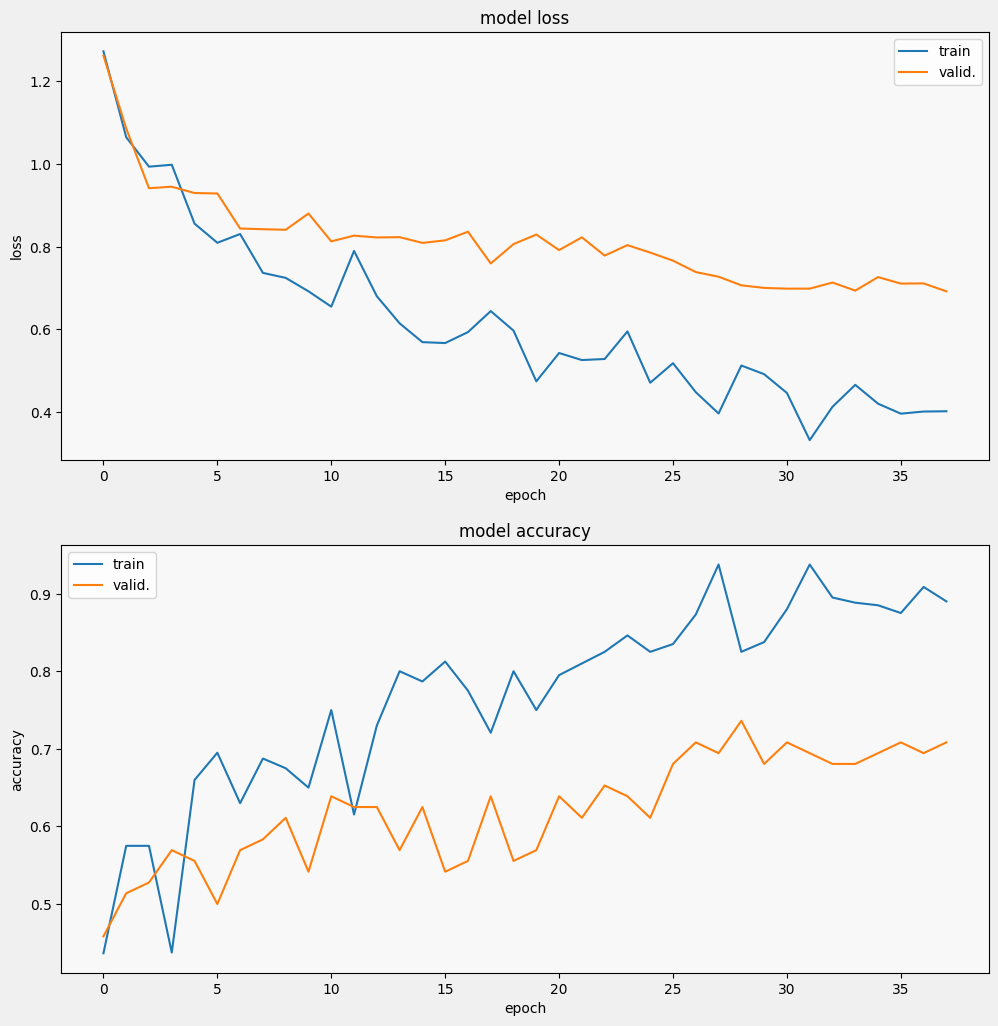

In [ ]:

# Function to display training curves for loss and accuracy
def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1:
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Display training curves for loss and accuracy
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)



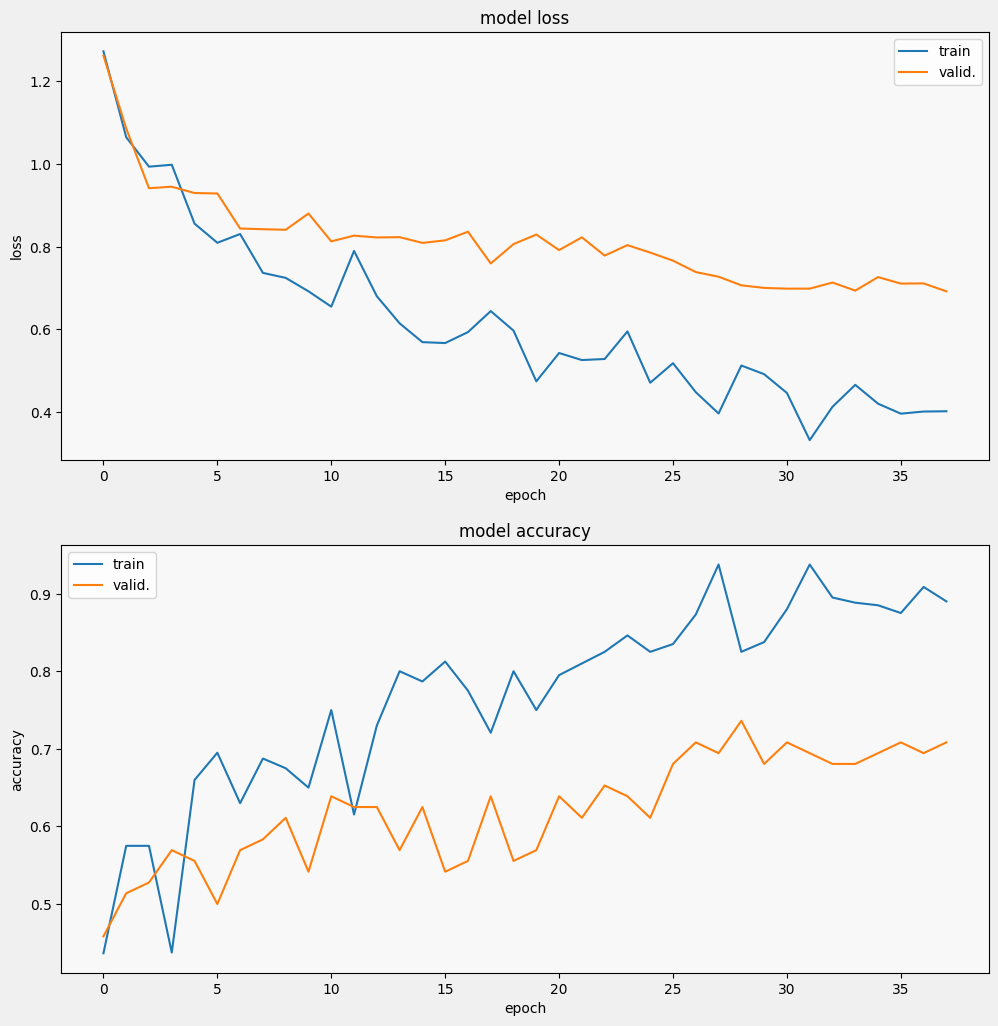

In [ ]:

# Function to display training curves for loss and accuracy
def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1:
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Display training curves for loss and accuracy
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step
The image belongs to class: normal


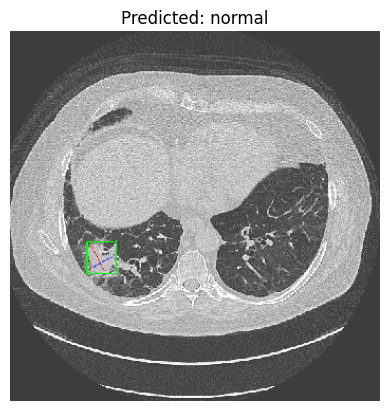

In [ ]:

# Function to load and preprocess an image for prediction
from tensorflow.keras.preprocessing import image
import numpy as np

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Load, preprocess, and predict the class of an image
img_path = '/content/drive/MyDrive/מחנה מדעי הנתונים לנוער תל אביב תשפד/Lung Cancer Data/valid/normal/003828_02_01_174.png'
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

# Display the image with the predicted class
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
The image belongs to class: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


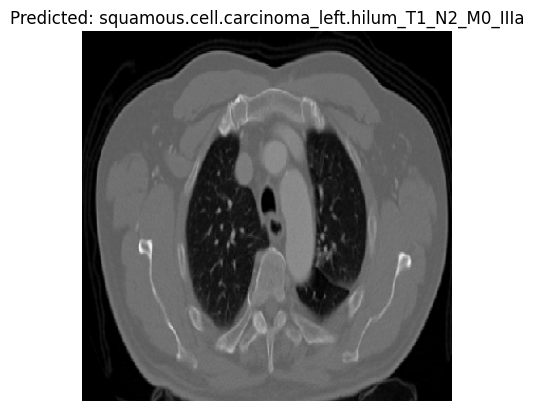

In [ ]:

from tensorflow.keras.preprocessing import image
import numpy as np

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Load an image from your drive
img_path = '/content/drive/MyDrive/מחנה מדעי הנתונים לנוער תל אביב תשפד/Lung Cancer Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000108 (3).png'
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

# Display the image
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
The image belongs to class: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


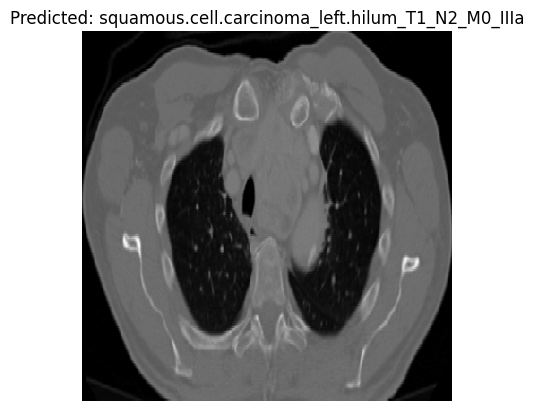

In [ ]:

from tensorflow.keras.preprocessing import image
import numpy as np

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Load an image from your drive
img_path = '/content/drive/MyDriveמחנה מדעי הנתונים לנוער תל אביב תשפד/Lung Cancer Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000113.png'
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

# Display the image
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
The image belongs to class: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib


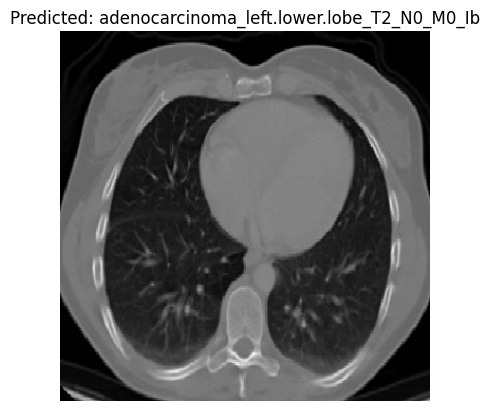

In [ ]:

from tensorflow.keras.preprocessing import image
import numpy as np

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Load an image from your drive
img_path = '/content/drive/MyDrive/מחנה מדעי הנתונים לנוער תל אביב תשפד/Lung Cancer Data/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000108 (7).png'
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

# Display the image
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()



Found 315 images belonging to 4 classes.
315/315 ━━━━━━━━━━━━━━━━━━━━ 272s 838ms/step


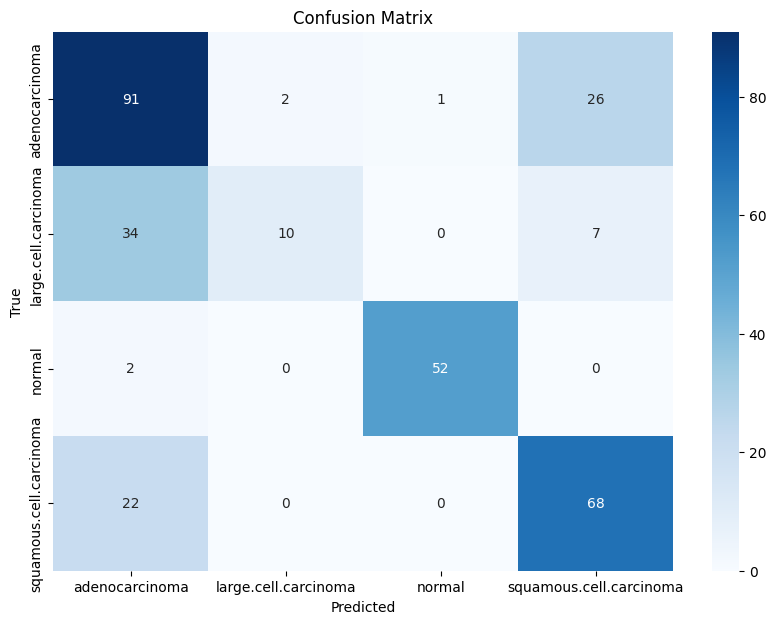

In [ ]:
# prompt: confusionmatrix

# Import necessary library
from sklearn.metrics import confusion_matrix

# Create a test data generator
test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=IMAGE_SIZE,
    batch_size=1,  # Set batch size to 1 for individual predictions
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False  # Important: Keep the order for matching predictions with true labels
)

# Get the true labels from the test generator
true_labels = test_generator.classes

# Predict the classes for all images in the test set
predictions = model.predict(test_generator, steps=test_generator.samples)
predicted_classes = np.argmax(predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()